In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sys
import tensorflow as tf
from tensorflow.keras import layers, Model

sys.path.append('..')
from src.data.make_dataset import make_dataset

In [2]:
DATA_PATH = '../data/processed/EEA-SK-Ba-trend.csv'
N_PAST = 48
N_FUTURE = 1

In [3]:
df = pd.read_csv(DATA_PATH)
df = df[['PM10 Concentration', 'PM2.5 Concentration']]

In [4]:
train_X, train_Y, val_X, val_Y, test_X = make_dataset(data_src=df, n_past=N_PAST, n_future=N_FUTURE)

In [5]:
in_scaler = StandardScaler()
out_scaler = StandardScaler()

train_X = train_X.reshape(-1, train_X.shape[-1])
train_X = in_scaler.fit_transform(train_X)
train_X = train_X.reshape(-1, N_PAST, train_X.shape[-1])

train_Y = train_Y.reshape(-1, train_Y.shape[-1])
train_Y = out_scaler.fit_transform(train_Y)
train_Y = train_Y.reshape(-1, N_FUTURE, train_Y.shape[-1])

val_X = val_X.reshape(-1, val_X.shape[-1])
val_X = in_scaler.transform(val_X)
val_X = val_X.reshape(-1, N_PAST, val_X.shape[-1])

val_Y = val_Y.reshape(-1, val_Y.shape[-1])
val_Y = out_scaler.transform(val_Y)
val_Y = val_Y.reshape(-1, N_FUTURE, val_Y.shape[-1])

real_values = test_X.copy()[:, -1, :]
test_X = test_X.reshape(-1, test_X.shape[-1])
test_X = in_scaler.transform(test_X)
test_X = test_X.reshape(-1, N_PAST, test_X.shape[-1])

In [6]:
print(f'Train set shape: {train_X.shape}         Train labels shape: {train_Y.shape}')
print(f'Validation set shape: {val_X.shape}     Validation labels shape: {val_Y.shape}')
print(f'Test set shape: {test_X.shape}')

Train set shape: (24498, 48, 2)         Train labels shape: (24498, 1, 2)
Validation set shape: (3458, 48, 2)     Validation labels shape: (3458, 1, 2)
Test set shape: (6966, 48, 2)


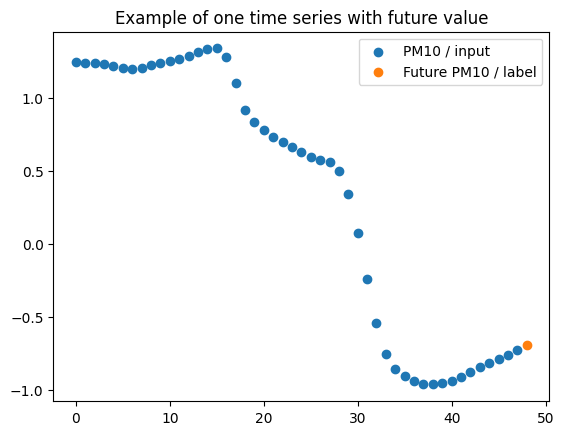

In [7]:
x = 3
plt.scatter(range(N_PAST), train_X[x, :, 1], label='PM10 / input')
tmp = np.empty((N_PAST, 1))
tmp[:] = np.nan
tmp = np.append(tmp, np.array(train_Y[x, 0, 1]))
plt.scatter(range(N_PAST + 1), tmp, label='Future PM10 / label')
plt.title('Example of one time series with future value')
plt.legend()
plt.show()

### Modelling

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, mode='min')

In [9]:
def lstm_model(lr=0.001):
    model = tf.keras.Sequential([
        layers.LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True),
        layers.LSTM(16, return_sequences=False),
        layers.Dropout(0.2),
        layers.Dense(4, activation='relu'),
        layers.Dense(2)
    ], name='LSTM')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )

    return model

lstm = lstm_model()
lstm.summary()


Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 32)            4480      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
Total params: 7694 (30.05 KB)
Trainable params: 7694 (30.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


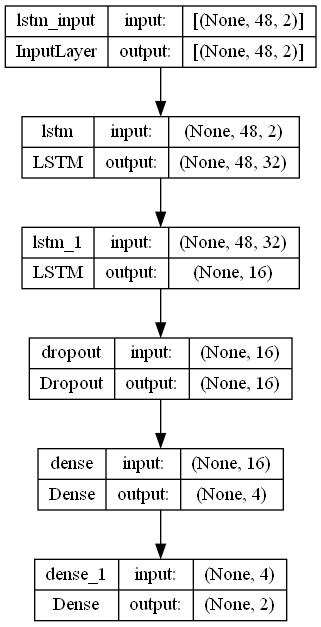

In [10]:
tf.keras.utils.plot_model(lstm, to_file='lstm.png', show_shapes=True)

In [11]:
def lstm_cnn_model(lr=0.001):
    model = tf.keras.Sequential([
        layers.Conv1D(32, activation='relu', kernel_size=3, input_shape=(train_X.shape[1], train_X.shape[2])),
        layers.MaxPooling1D(2),
        layers.Conv1D(32, activation='relu', kernel_size=3),
        layers.MaxPooling1D(2),
        layers.LSTM(32, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True),
        layers.LSTM(16, activation='relu', return_sequences=False),
        layers.Dropout(0.2),
        layers.Dense(4, activation='relu'),
        layers.Dense(2)
    ], name='LSTM_CNN')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )

    return model

lstm_cnn = lstm_cnn_model()
lstm_cnn.summary()


Model: "LSTM_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 32)            224       
                                                                 
 max_pooling1d (MaxPooling1  (None, 23, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 21, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 10, 32)            0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 16)                31

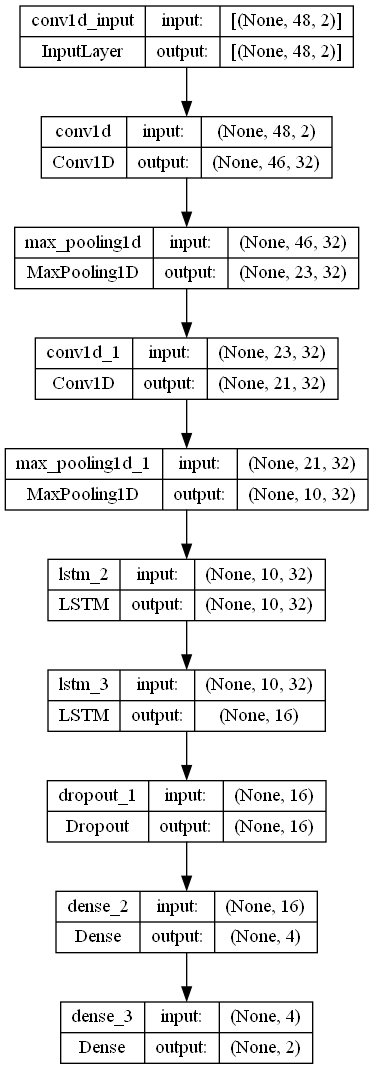

In [12]:
tf.keras.utils.plot_model(lstm_cnn, to_file='lstm_cnn.png', show_shapes=True)

In [13]:
def lstm_cnn_skip_model(lr=0.001):
    inputs = layers.Input(shape=(train_X.shape[1], train_X.shape[2]))
    conv1 = layers.Conv1D(32, activation='relu', kernel_size=3)(inputs)
    pool1 = layers.MaxPooling1D(2)(conv1)
    conv2 = layers.Conv1D(32, activation='relu', kernel_size=3)(pool1)
    pool2 = layers.MaxPooling1D(2)(conv2)
    lstm1 = layers.LSTM(32, activation='relu', return_sequences=True)(pool2)
    lstm2 = layers.LSTM(16, activation='relu', return_sequences=False)(lstm1)

    lstm3 = layers.LSTM(16, activation='relu', return_sequences=False)(inputs)
    
    concat = layers.Concatenate()([lstm2, lstm3])
    drop1 = layers.Dropout(0.2)(concat)
    dense1 = layers.Dense(4, activation='relu')(drop1)
    outputs = layers.Dense(2)(dense1)

    model = Model(inputs=inputs, outputs=outputs, name='LSTM_CNN_SKIP')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )

    return model

lstm_cnn_skip = lstm_cnn_skip_model()
lstm_cnn_skip.summary()

Model: "LSTM_CNN_SKIP"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 2)]              0         []                            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 46, 32)               224       ['input_1[0][0]']             
                                                                                                  
 max_pooling1d_2 (MaxPoolin  (None, 23, 32)               0         ['conv1d_2[0][0]']            
 g1D)                                                                                             
                                                                                                  
 conv1d_3 (Conv1D)           (None, 21, 32)               3104      ['max_pooling1d_2[

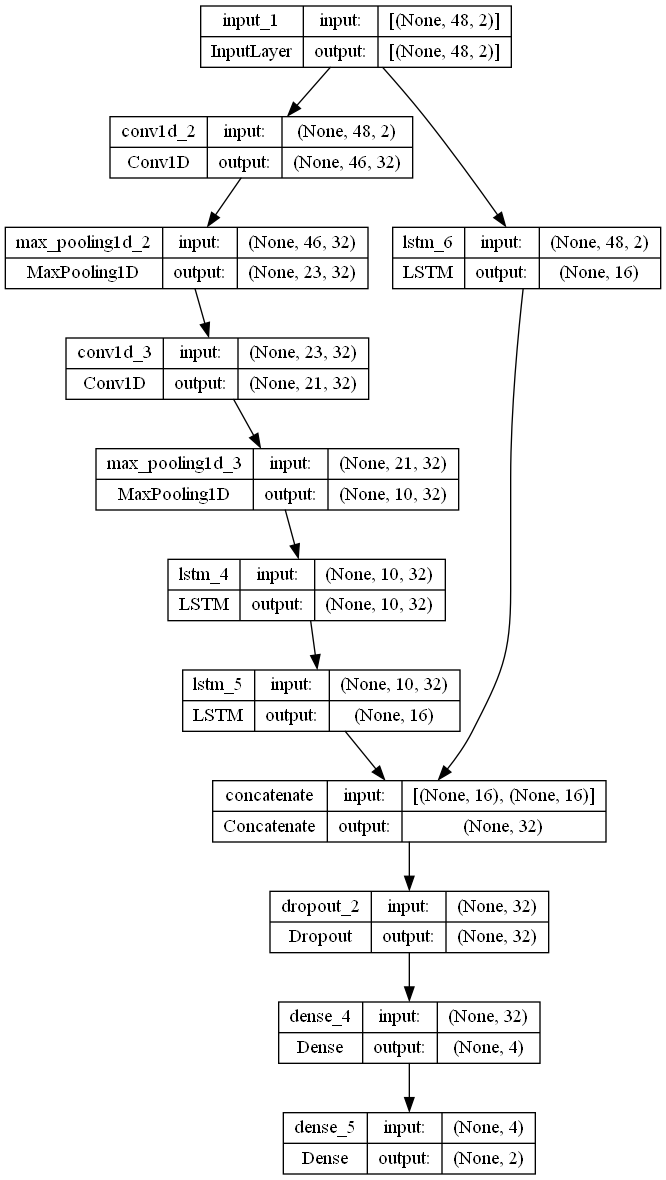

In [14]:
tf.keras.utils.plot_model(lstm_cnn_skip, to_file='lstm_cnn_skip.png', show_shapes=True)

### Model training

In [15]:
model1_hist = lstm.fit(
    train_X, train_Y,
    validation_data=(val_X, val_Y),
    epochs=25,
    batch_size=64,
    #callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/25

383/383 [==============================] - 12s 22ms/step - loss: 1.0006 - mean_absolute_error: 0.7950 - mean_absolute_percentage_error: 109.2878 - val_loss: 1.3306 - val_mean_absolute_error: 0.9362 - val_mean_absolute_percentage_error: 101.3904
Epoch 2/25
383/383 [==============================] - 8s 20ms/step - loss: 1.0001 - mean_absolute_error: 0.7947 - mean_absolute_percentage_error: 103.5767 - val_loss: 1.3276 - val_mean_absolute_error: 0.9356 - val_mean_absolute_percentage_error: 101.4230
Epoch 3/25
383/383 [==============================] - 8s 20ms/step - loss: 1.0001 - mean_absolute_error: 0.7947 - mean_absolute_percentage_error: 108.7262 - val_loss: 1.3238 - val_mean_absolute_error: 0.9350 - val_mean_absolute_percentage_error: 105.8910
Epoch 4/25
383/383 [==============================] - 8s 20ms/step - loss: 1.0001 - mean_absolute_error: 0.7958 - mean_absolute_percentage_error: 103.6854 - val_loss: 1.3318 - val_mean_absolute_error: 0.9364 - val_mean_absolute_perce

In [16]:
model2_hist = lstm_cnn.fit(
    train_X, train_Y,
    validation_data=(val_X, val_Y),
    epochs=25,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/25
383/383 [==============================] - 6s 9ms/step - loss: 1.0002 - mean_absolute_error: 0.7949 - mean_absolute_percentage_error: 103.4086 - val_loss: 1.3339 - val_mean_absolute_error: 0.9368 - val_mean_absolute_percentage_error: 103.2818
Epoch 2/25
383/383 [==============================] - 3s 8ms/step - loss: 1.0001 - mean_absolute_error: 0.7950 - mean_absolute_percentage_error: 103.0184 - val_loss: 1.3318 - val_mean_absolute_error: 0.9365 - val_mean_absolute_percentage_error: 100.8177
Epoch 3/25
383/383 [==============================] - 3s 7ms/step - loss: 1.0000 - mean_absolute_error: 0.7951 - mean_absolute_percentage_error: 103.8960 - val_loss: 1.3358 - val_mean_absolute_error: 0.9373 - val_mean_absolute_percentage_error: 102.7192
Epoch 4/25
383/383 [==============================] - 3s 7ms/step - loss: 1.0001 - mean_absolute_error: 0.7953 - mean_absolute_percentage_error: 102.2422 - val_loss: 1.3327 - val_mean_absolute_error: 0.9367 - val_mean_absolute_percentage_

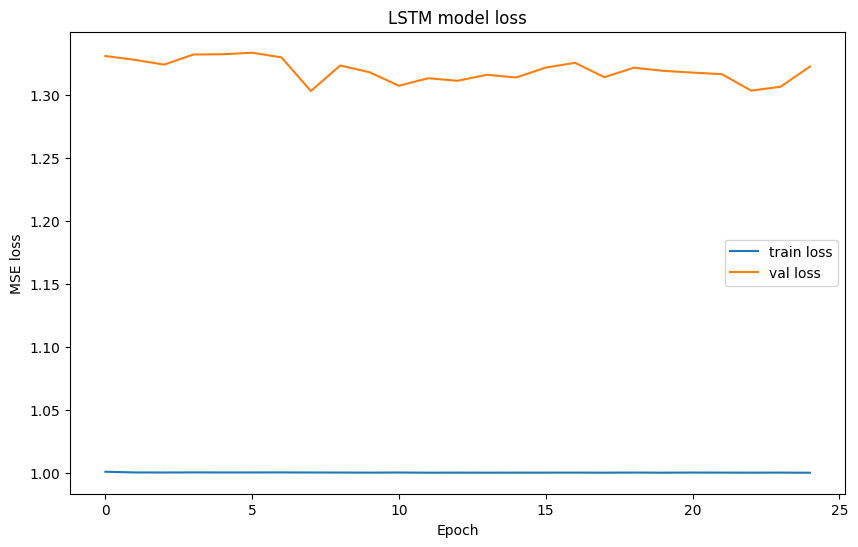

In [17]:
# plot history of lstm model
plt.figure(figsize=(10, 6))
plt.plot(model1_hist.history['loss'], label='train loss')
plt.plot(model1_hist.history['val_loss'], label='val loss')
plt.title('LSTM model loss')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.show()

218/218 [==============================] - 2s 5ms/step
LSTM predictions shape: (6966, 2)
LSTM predictions shape: (6966, 2)


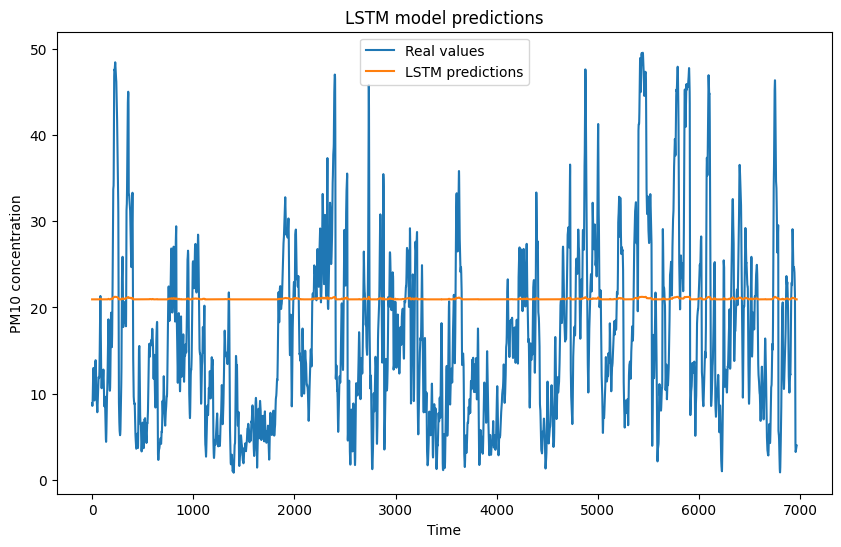

In [18]:
# make predictions using lstm
lstm_preds = lstm.predict(test_X)
print(f'LSTM predictions shape: {lstm_preds.shape}')
lstm_preds = out_scaler.inverse_transform(lstm_preds)
print(f'LSTM predictions shape: {lstm_preds.shape}')
lstm_preds = lstm_preds[:, 0]

# plot predictions
plt.figure(figsize=(10, 6))
plt.plot(real_values[:, 0], label='Real values')
plt.plot(lstm_preds, label='LSTM predictions')
plt.title('LSTM model predictions')
plt.xlabel('Time')
plt.ylabel('PM10 concentration')
plt.legend()
plt.show()

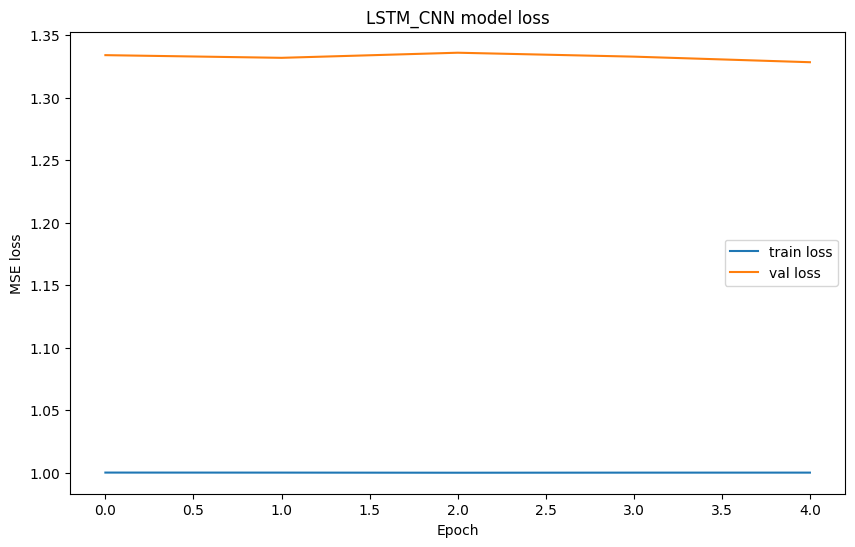

In [19]:
# plot history of lstm model
plt.figure(figsize=(10, 6))
plt.plot(model2_hist.history['loss'], label='train loss')
plt.plot(model2_hist.history['val_loss'], label='val loss')
plt.title('LSTM_CNN model loss')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.show()

218/218 [==============================] - 1s 2ms/step
LSTM_CNN predictions shape: (6966, 2)
LSTM_CNN predictions shape: (6966, 2)


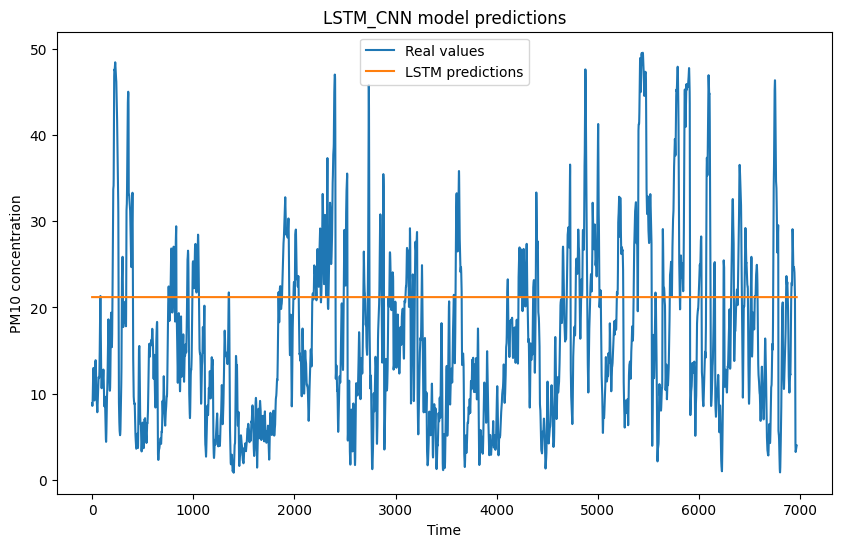

In [20]:
# make predictions using lstm
lstm_preds = lstm_cnn.predict(test_X)
print(f'LSTM_CNN predictions shape: {lstm_preds.shape}')
lstm_preds = out_scaler.inverse_transform(lstm_preds)
print(f'LSTM_CNN predictions shape: {lstm_preds.shape}')
lstm_preds = lstm_preds[:, 0]

# plot predictions
plt.figure(figsize=(10, 6))
plt.plot(real_values[:, 0], label='Real values')
plt.plot(lstm_preds, label='LSTM predictions')
plt.title('LSTM_CNN model predictions')
plt.xlabel('Time')
plt.ylabel('PM10 concentration')
plt.legend()
plt.show()